In [1]:
import pandas as pd
import netCDF4 as nc
import numpy as np
import cv2
import os
import errno
import geopandas as gpd
import seaborn as sns
import shapely
from shapely.geometry import shape, Polygon, Point, MultiPoint, box, LineString
import xarray as xr
from sklearn.linear_model import LinearRegression
from pyproj import Geod
from shapely import wkt

In [2]:
def polyarc(lon,lat,r1,r2,r3,r4):
    ctpos = [lon,lat]
    u=111.1
    arc = arco(r1/u,r2/u,r3/u,r4/u,ctpos)
    polyar = Polygon(list(zip(arc[0],arc[1])))
    return polyar
def polfun(x):
    return polyarc(x['lon'],x['lat'],x['TCOR'],x['TCOR'],x['TCOR'],x['TCOR'])
def arco(r1,r2,r3,r4,c):
    ang = [np.arange(0,np.pi/2,0.01), np.arange(np.pi/2,np.pi,0.01),
           np.arange(np.pi,(3/2)*np.pi,0.01),np.arange((3/2)*np.pi,2*np.pi,0.01)]
    grafx, grafy = [], []
    for i,r in enumerate([r1,r2,r3,r4]):
        grafx.append(r*np.cos(ang[i])+c[0])
        grafy.append(r*np.sin(ang[i])+c[1])
    return (np.concatenate(grafx, axis = 0),np.concatenate(grafy, axis = 0))
def dateind(hh,dd,mm,yy):
    suma = 0
    if (yy == np.arange(2000,2021,4)).any():
        mes = [744,696,744,720,744,720,744,744,720,744,720,744]
    else:
        mes = [744,672,744,720,744,720,744,744,720,744,720,744]

    for i in np.arange(1,mm):
        suma = (suma+mes[i-1])
    suma = suma+(dd-1)*24+hh
    return suma


def areapoly(geom):
    geod = Geod(ellps="WGS84")
    area = abs(geod.geometry_area_perimeter(geom)[0])/1e+6
    return area

In [3]:
import numpy as np
import pandas as pd
import geopandas as gpd
import shapely.geometry
import xarray as xr

def cargar_datos_climaticos(yy):
    """
    Carga los datos climáticos para un año específico.

    Parámetros:
    yy (int): Año para el cual se cargan los datos.

    Retorno:
    dict: Contiene los datasets de humedad, cizalladura, divergencia, velocidad vertical y vorticidad.
    """
    hum = xr.open_dataset(f'D:/hum/hum{yy}.nc')
    wshr = xr.open_dataset(f'D:/ws/ws{yy}.nc')
    div = xr.open_dataset(f'D:/divergence/velver{yy}.nc')
    vver = xr.open_dataset(f'D:/vver/velver{yy}.nc')
    vor = xr.open_dataset(f'D:/vor/vor{yy}.nc')
    
    return {'hum': hum, 'wshr': wshr, 'div': div, 'vver': vver, 'vor': vor}

def extraer_valores_por_tiempo(datos, time):
    """
    Extrae los valores de los datasets climáticos para un tiempo específico.

    Parámetros:
    datos (dict): Datasets climáticos.
    time (int): Índice temporal para el cual se extraen los datos.

    Retorno:
    dict: Contiene los valores de humedad, cizalladura, divergencia, velocidad vertical y vorticidad.
    """
    hum_val = datos['hum'].r[time].data
    ciz_val = datos['wshr'].value[time].data
    div_val = datos['div'].d[time].data
    vvr_val = datos['vver'].w[time].data
    vor_val = datos['vor'].vo[time].data
    
    return {'hum': hum_val, 'ciz': ciz_val, 'div': div_val, 'vvr': vvr_val, 'vor': vor_val}

def crear_dataframe_climatico(lat, lon, valores):
    """
    Crea un DataFrame a partir de los valores climáticos filtrados.

    Parámetros:
    lat, lon (arrays): Coordenadas latitudinales y longitudinales.
    valores (dict): Valores climáticos para las coordenadas.

    Retorno:
    DataFrame: Contiene los datos climáticos organizados por latitud y longitud.
    """
    x, y = np.meshgrid(lon, lat)
    indx = np.where(valores['hum'] != -9999)  # Filtra los valores no válidos
    indxx, indxy = x[indx], y[indx]
    
    df = pd.DataFrame({
        'lon': indxx, 
        'lat': indxy, 
        'hum': valores['hum'][indx], 
        'ciz': valores['ciz'][indx], 
        'div': valores['div'][indx], 
        'vvr': valores['vvr'][indx], 
        'vor': valores['vor'][indx]
    })
    
    return df

def filtrar_por_radio(df, ctpos, R_max, i):
    """
    Filtra los datos en función de un radio alrededor de una posición central.

    Parámetros:
    df (DataFrame): DataFrame de valores climáticos.
    ctpos (tuple): Posición central (longitud, latitud).
    R_max (Series): Radio máximo para cada punto.
    i (int): Índice actual.

    Retorno:
    DataFrame: DataFrame filtrado según el radio.
    """
    factor = R_max.iloc[i] / 111.1
    f1 = (ctpos[1] - factor - 1 < df.lat) & (df.lat < ctpos[1] + factor + 1)
    f2 = (ctpos[0] - factor - 1 < df.lon) & (df.lon < ctpos[0] + factor + 1)
    return df.loc[f1 & f2]

def calcular_promedios(dfSP, alex, i):
    """
    Calcula los promedios de los valores climáticos y los asigna al DataFrame original.

    Parámetros:
    dfSP (GeoDataFrame): DataFrame geoespacial filtrado.
    alex (DataFrame): DataFrame original con los datos de entrada.
    i (int): Índice actual.

    Retorno:
    None: Los valores son actualizados directamente en el DataFrame `alex`.
    """
    alex.loc[i, 'hum'] = dfSP['hum'].mean()
    alex.loc[i, 'ciz'] = dfSP['ciz'].mean()
    alex.loc[i, 'div'] = dfSP['div'].mean()
    alex.loc[i, 'vvr'] = dfSP['vvr'].mean()
    alex.loc[i, 'vor'] = dfSP['vor'].mean()

def var_env_mean(alex):
    """
    Función principal que realiza el cálculo de los valores promedio del entorno.
    """
    geometry = alex.apply(polfun, axis=1)  # Aplicar función de polígono para generar geometrías
    alex['geometry'] = geometry  # Añadir geometría al DataFrame

    for i in range(len(alex)):
        # Obtener datos específicos por fila
        hh = alex.hh.iloc[i]
        yy = alex.yy.iloc[i]
        dd = alex.dd.iloc[i]
        mm = alex.mm.iloc[i]

        # Cargar datos climáticos
        datos = cargar_datos_climaticos(yy)
        lat = datos['hum'].latitude.data
        lon = datos['hum'].longitude.data

        # Obtener el índice temporal
        time = dateind(hh, dd, mm, yy)
        
        # Extraer los valores climáticos
        valores = extraer_valores_por_tiempo(datos, time)
        
        # Crear DataFrame con los valores extraídos
        df = crear_dataframe_climatico(lat, lon, valores)
        
        # Posición central y filtrado por radio
        ctpos = (alex.lon.iloc[i], alex.lat.iloc[i])
        R_max = alex.loc[:, ['TCOR']].max(axis=1)
        df = filtrar_por_radio(df, ctpos, R_max, i)
        
        # Convertir DataFrame a GeoDataFrame
        dfSP = gpd.GeoDataFrame(df, geometry=[shapely.geometry.Point(xy) for xy in zip(df.lon, df.lat)])
        
        # Filtrar puntos dentro del polígono
        ipn = dfSP['geometry'].intersects(alex['geometry'][i])
        dfSP = dfSP.loc[ipn].reset_index(drop=True)
        
        # Calcular promedios y actualizar valores en el DataFrame original
        calcular_promedios(dfSP, alex, i)
        
        print(f'Procesado: {i+1}/{len(alex)}')
    
    # Calcular área del polígono
    alex['areap'] = alex['geometry'].apply(areapoly)
    
    # Retornar DataFrame sin la columna de geometría
    return alex.drop(['geometry'], axis=1).reset_index(drop=True)


In [4]:
names = ['ct','date', 'time', 'lat', 'lon', 'MWS', 'CPSL', 'ERMWS', 'R34', 'R50', 'R64', 'R100', 'TCOR']
alex = pd.read_csv('../NA_PA.dat', sep="\t", skip_blank_lines=True, header = None, names = names)

In [5]:
# Crear nuevas columnas para año, mes, día
# Separar la columna fecha en año, mes, día y tiempo
alex['date'] = pd.to_datetime(alex['date'])
alex['yy'] = alex['date'].dt.year
alex['mm'] = alex['date'].dt.month
alex['dd'] = alex['date'].dt.day

In [6]:
alex['hh'] = pd.to_datetime(alex['time'], format='%H:%M').dt.hour

In [7]:
df = alex.head(15).copy()

In [8]:
alex

,ct,date,time,lat,lon,MWS,CPSL,ERMWS,R34,R50,R64,R100,TCOR,yy,mm,dd,hh
0,AL012000,2000-06-07,18:00,21.0,-93.0,46.25,1008,54.45,NaN,NaN,NaN,NaN,673.5,2000,6,7,18
1,AL012000,2000-06-08,00:00,20.9,-92.8,46.25,1009,54.36,NaN,NaN,NaN,NaN,673.0,2000,6,8,0
2,AL012000,2000-06-08,06:00,20.7,-93.1,46.25,1010,54.17,NaN,NaN,NaN,NaN,671.5,2000,6,8,6
3,AL012000,2000-06-08,12:00,20.8,-93.5,46.25,1010,54.27,NaN,NaN,NaN,NaN,672.0,2000,6,8,12
4,AL022000,2000-06-23,00:00,9.5,-19.8,46.25,1010,44.83,NaN,NaN,NaN,NaN,598.0,2000,6,23,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11127,AL312020,2020-11-17,12:00,13.7,-84.7,138.70,965,32.32,194.0,103.5,56.0,NaN,766.0,2020,11,17,12
11128,AL312020,2020-11-17,18:00,13.7,-85.7,101.70,988,37.90,143.5,55.0,NaN,NaN,758.5,2020,11,17,18
11129,AL312020,2020-11-18,00:00,13.8,-86.7,74.00,1000,42.78,78.5,NaN,NaN,NaN,721.0,2020,11,18,0
11130,AL312020,2020-11-18,06:00,13.8,-87.8,64.75,1005,44.52,50.5,NaN,NaN,NaN,698.0,2020,11,18,6


In [9]:
def ejecutar_var_env_mean(alex):
    """
    Ejecuta en orden las funciones necesarias para calcular los promedios ambientales
    en el DataFrame `alex`.

    Parámetros:
    alex (DataFrame): DataFrame con los datos iniciales.

    Retorno:
    DataFrame: DataFrame actualizado con los valores promedios calculados.
    """
    # Aplicar la función `var_env_mean` que integra todo el flujo
    resultado = var_env_mean(alex)
    return resultado



In [12]:
# Suponiendo que `alex` ya está definido y cargado con datos
resultado = ejecutar_var_env_mean(df)

# Imprimir o guardar el resultado
# resultado.to_csv('env_na_tcor.dat', sep = '\t', index = False, header = False)

FileNotFoundError: [Errno 2] No such file or directory: 'D:\\hum\\hum2000.nc'

In [17]:
colum =  alex.columns.to_list()

In [18]:
col_ext = ['hum', 'wshr', 'div', 'vver', 'vor']

In [20]:
names = colum + col_ext

In [24]:
names 

['ct',
 'date',
 'time',
 'lat',
 'lon',
 'MWS',
 'CPSL',
 'ERMWS',
 'R34',
 'R50',
 'R64',
 'R100',
 'TCOR',
 'yy',
 'mm',
 'dd',
 'hh',
 'hum',
 'wshr',
 'div',
 'vver',
 'vor']

In [46]:
resultado = pd.read_csv('env_na_tcor.dat', sep="\t", skip_blank_lines=True, header = None, names = names)

TypeError: read_csv() got an unexpected keyword argument 'index'

In [45]:
resultado.head()

,ct,date,time,lat,lon,MWS,CPSL,ERMWS,R34,R50,...,TCOR,yy,mm,dd,hh,hum,wshr,div,vver,vor
AL012000,2000-06-07,18:00,21.0,-93.0,46.25,1008,54.45,NaN,NaN,NaN,...,2000,6,7,18,75.488944,13.392222,0.000008,-0.122911,0.000005,1.327132e+06
AL012000,2000-06-08,00:00,20.9,-92.8,46.25,1009,54.36,NaN,NaN,NaN,...,2000,6,8,0,76.219581,15.273763,0.000008,-0.085442,0.000007,1.326030e+06
AL012000,2000-06-08,06:00,20.7,-93.1,46.25,1010,54.17,NaN,NaN,NaN,...,2000,6,8,6,75.804076,15.771088,0.000006,-0.045018,0.000007,1.321845e+06
AL012000,2000-06-08,12:00,20.8,-93.5,46.25,1010,54.27,NaN,NaN,NaN,...,2000,6,8,12,73.924682,16.431889,0.000005,-0.064399,0.000007,1.322956e+06
AL022000,2000-06-23,00:00,9.5,-19.8,46.25,1010,44.83,NaN,NaN,NaN,...,2000,6,23,0,65.828268,13.025788,0.000013,-0.075437,0.000007,1.104169e+06


In [53]:
df = resultado[['hum', 'wshr', 'div', 'vver', 'vor']].copy()

In [54]:
statistics = df.describe()
statistics

,hum,wshr,div,vver,vor
count,10760.000000,1.076000e+04,10760.000000,10760.000000,1.113200e+04
mean,16.063198,5.159263e-06,-0.064740,0.000009,1.772767e+06
std,4.659157,6.162555e-06,0.070933,0.000010,3.354254e+05
min,2.694172,-2.821913e-05,-0.473039,-0.000044,5.267632e+05
25%,12.871239,9.177552e-07,-0.106223,0.000003,1.523001e+06
50%,15.454890,4.575193e-06,-0.056416,0.000009,1.793642e+06
75%,18.436355,8.934924e-06,-0.015090,0.000016,2.043655e+06
max,44.608017,3.453048e-05,0.401880,0.000058,2.353081e+06


In [55]:
df[statistics.columns]

,hum,wshr,div,vver,vor
AL012000,13.392222,0.000008,-0.122911,0.000005,1.327132e+06
AL012000,15.273763,0.000008,-0.085442,0.000007,1.326030e+06
AL012000,15.771088,0.000006,-0.045018,0.000007,1.321845e+06
AL012000,16.431889,0.000005,-0.064399,0.000007,1.322956e+06
AL022000,13.025788,0.000013,-0.075437,0.000007,1.104169e+06
...,...,...,...,...,...
AL312020,15.156918,0.000017,-0.200010,0.000017,1.784097e+06
AL312020,16.757982,0.000021,-0.273577,0.000017,1.749392e+06
AL312020,15.715594,0.000028,-0.269371,0.000017,1.580296e+06
AL312020,14.973785,0.000022,-0.212735,0.000021,1.481227e+06


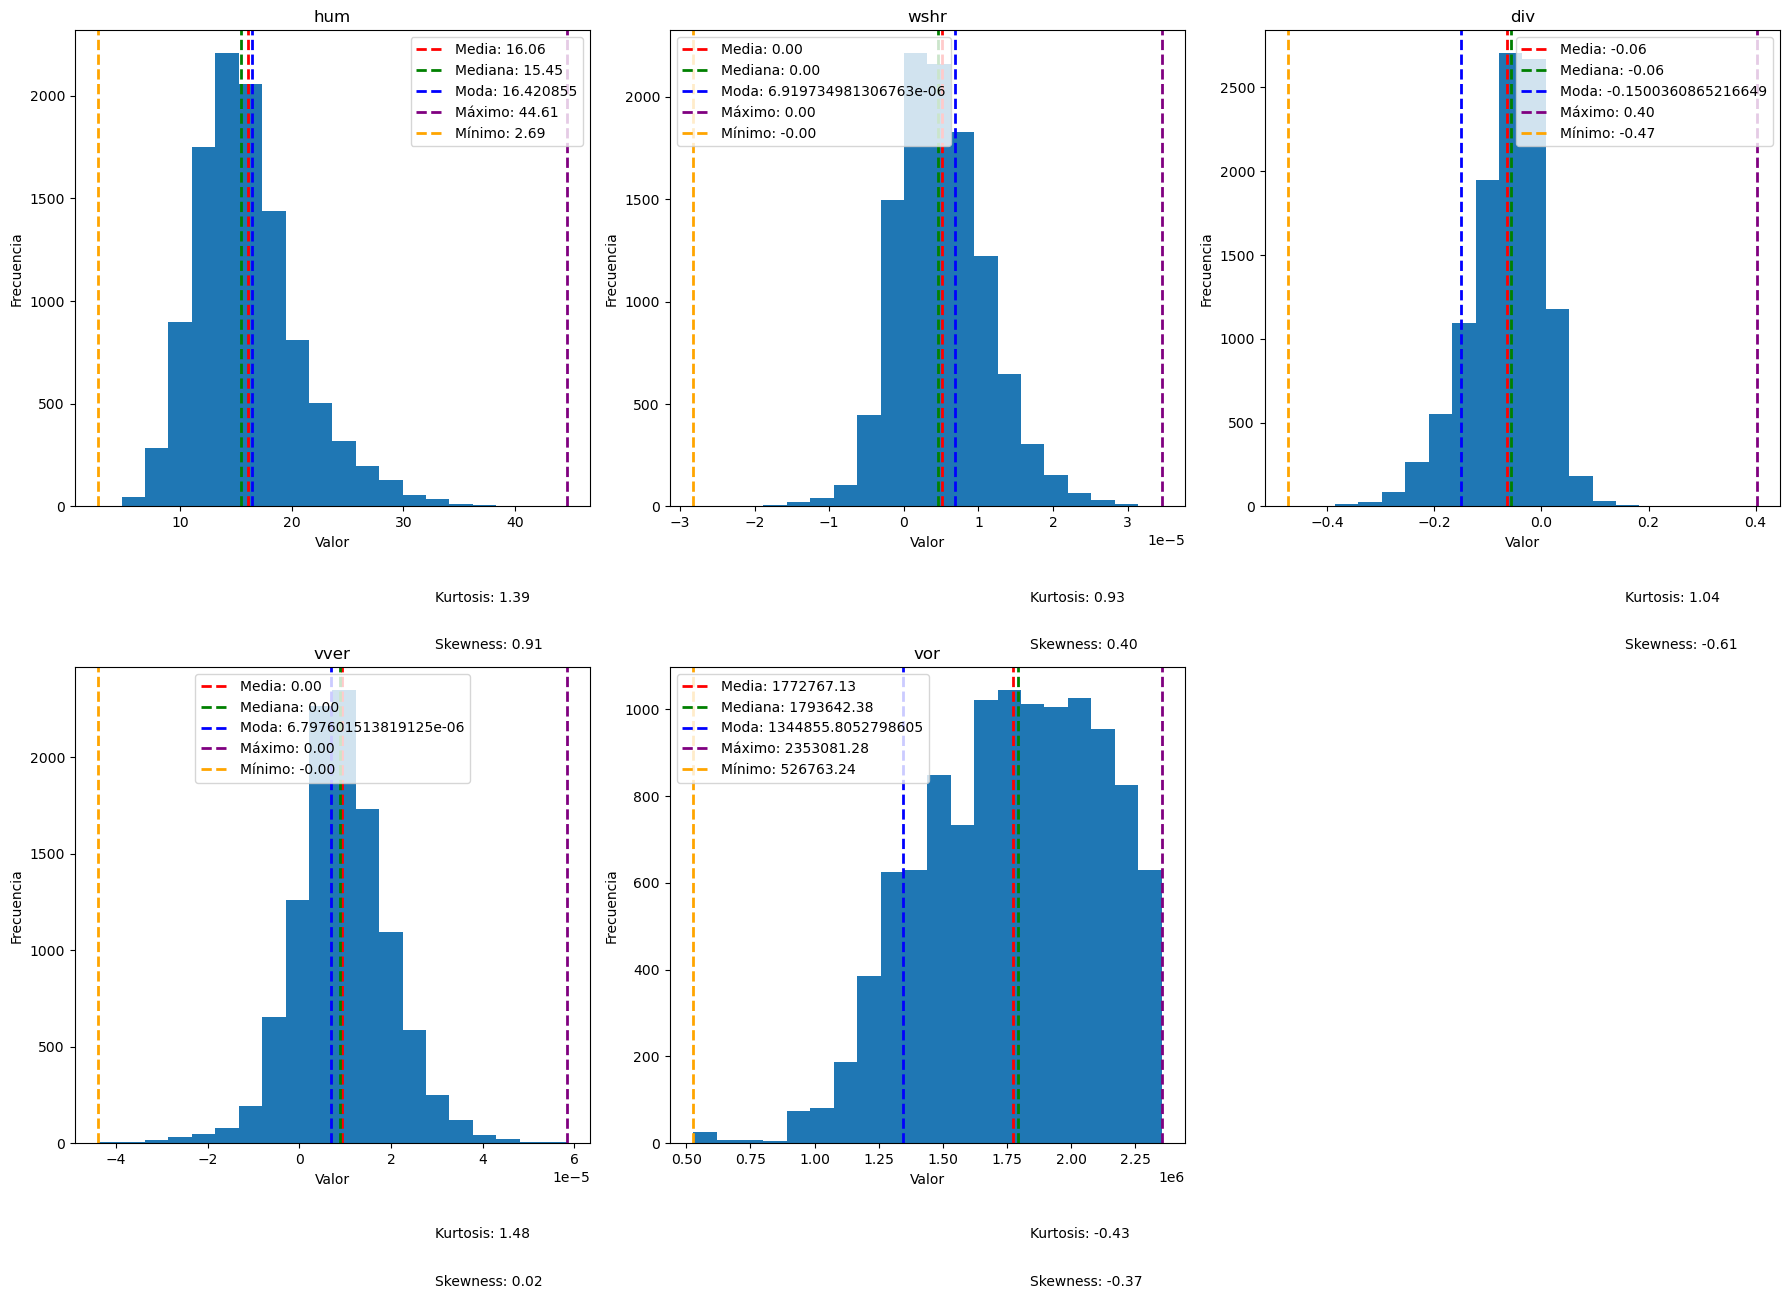

In [56]:
import matplotlib.pyplot as plt

# Ajusta el tamaño de la figura según tus preferencias
plt.figure(figsize=(18, 18))

# Define el número de filas y columnas para la cuadrícula de subtramas
num_rows, num_cols = 3,3
# Crea una cuadrícula de subtramas para cada columna
for i, column in enumerate(df[statistics.columns].columns):
    plt.subplot(num_rows, num_cols, i + 1)
    plt.hist(df[column], bins=20)  # Personaliza el número de bins según tus necesidades
    plt.title(column)
    plt.xlabel('Valor')
    plt.ylabel('Frecuencia')

    # Calcula la media, mediana y moda
    mean = df[column].mean()
    median = df[column].median()
    frecuencias = df[column].value_counts()
    mode = frecuencias.idxmax()

    # Calcula curtosis y asimetría (skewness)
    kurtosis_value = df[column].kurtosis()
    skewness_value = df[column].skew()

    # Encuentra los valores máximos y mínimos
    max_value = df[column].max()
    min_value = df[column].min()

    # Agrega líneas verticales para marcar la media, mediana, moda, máximo y mínimo
    plt.axvline(mean, color='red', linestyle='dashed', linewidth=2, label=f'Media: {mean:.2f}')
    plt.axvline(median, color='green', linestyle='dashed', linewidth=2, label=f'Mediana: {median:.2f}')
    plt.axvline(mode, color='blue', linestyle='dashed', linewidth=2, label=f'Moda: {mode}')
    plt.axvline(max_value, color='purple', linestyle='dashed', linewidth=2, label=f'Máximo: {max_value:.2f}')
    plt.axvline(min_value, color='orange', linestyle='dashed', linewidth=2, label=f'Mínimo: {min_value:.2f}')

    # Anota los valores de kurtosis y asimetría en la parte inferior
    plt.text(0.7, -0.2, f'Kurtosis: {kurtosis_value:.2f}', transform=plt.gca().transAxes, color='k')
    plt.text(0.7, -0.3, f'Skewness: {skewness_value:.2f}', transform=plt.gca().transAxes, color='k')

    plt.legend()

# Ajusta el espaciado entre las subtramas
plt.tight_layout()

In [62]:
# Define las columnas que deseas analizar para valores atípicos
columns_to_analyze = ['hum', 'wshr', 'div', 'vver', 'vor']

# Ajusta el tamaño de la figura
plt.figure(figsize=(12, 8))

# Itera a través de las columnas y crea box plots para identificar valores atípicos
for i, column in enumerate(df.columns):
    plt.subplot0(3, 2, i+1)  # 2 filas, 3 columnas
    plt.boxplot(df[column])
    plt.title(column)
    plt.ylabel('Valor')

# Ajusta el espaciado entre las subtramas
plt.tight_layout()

# Identifica valores atípicos usando la regla del rango intercuartílico (IQR)
outliers = {}
for column in df.columns:
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    column_outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
    outliers[column] = column_outliers

AttributeError: module 'matplotlib.pyplot' has no attribute 'subplot0'

<Figure size 1200x800 with 0 Axes>

<Axes: >

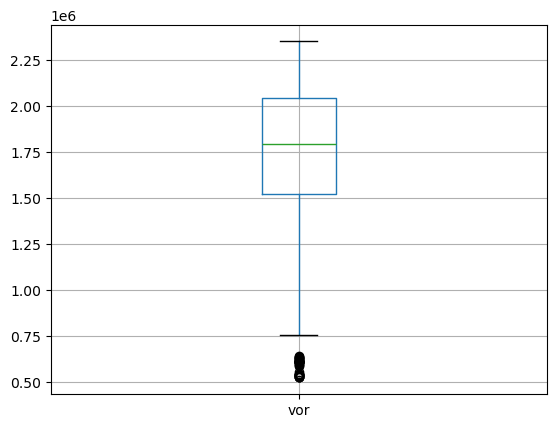

In [66]:
df[['vor']].boxplot()

<Axes: >

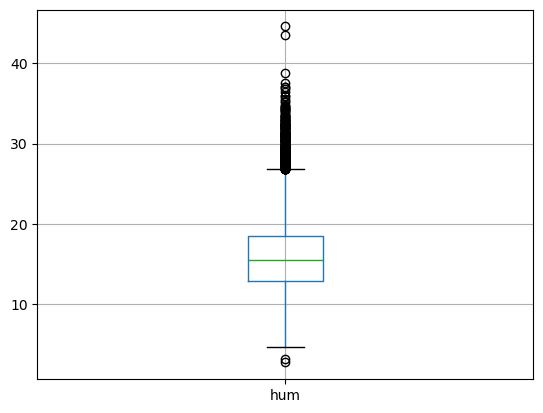

In [67]:
df[['hum']].boxplot()